In [75]:
%%capture
import scikits.samplerate
import sklearn
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import logging
import theano.tensor as T
import lasagne
import logging
log = logging.getLogger()
log.setLevel("DEBUG")
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (16.0, 1.0)
matplotlib.rcParams['font.size'] = 7
from braindecode.scripts.print_results import ResultPrinter
import theano
import scipy.signal
import numpy as np
from braindecode.veganlasagne.layer_util import print_layers
from braindecode.results.results import ResultPool

In [5]:
from braindecode.csp.experiment import CSPExperiment
from braindecode.datasets.loaders import BBCIDataset
from braindecode.datasets.sensor_positions import get_C_sensors_sorted, get_EEG_sensors_sorted
from braindecode.mywyrm.processing import segment_dat_fast

### Long Negative Drifts

* Can be discovered by plotting means of trials
* Reason unclear, seems technical

In [4]:
anwe_cnt = BBCIDataset('data/BBCI-without-last-runs/AnWeMoSc1S001R01_ds10_1-12.BBCI.mat').load()

marker_def = dict([(str(i_class), [i_class]) for i_class in range(1,5)])
anwe_epo = segment_dat_fast(anwe_cnt,marker_def=marker_def, ival=[0,4000])

#### Mean value for each trial for all channels

* Notice drop somewhere around trial 700

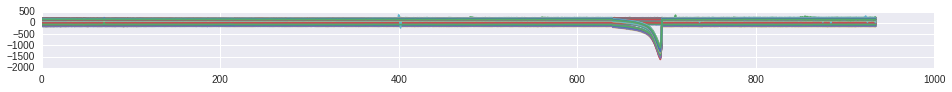

In [12]:
plt.plot(np.mean(anwe_epo.data, axis=1))
None

#### Topo Plot

* Rows of sensors seem to be affected
* plot of means for trials 650 to 750

In [13]:
from braindecode.analysis.plot_util import plot_head_signals_tight

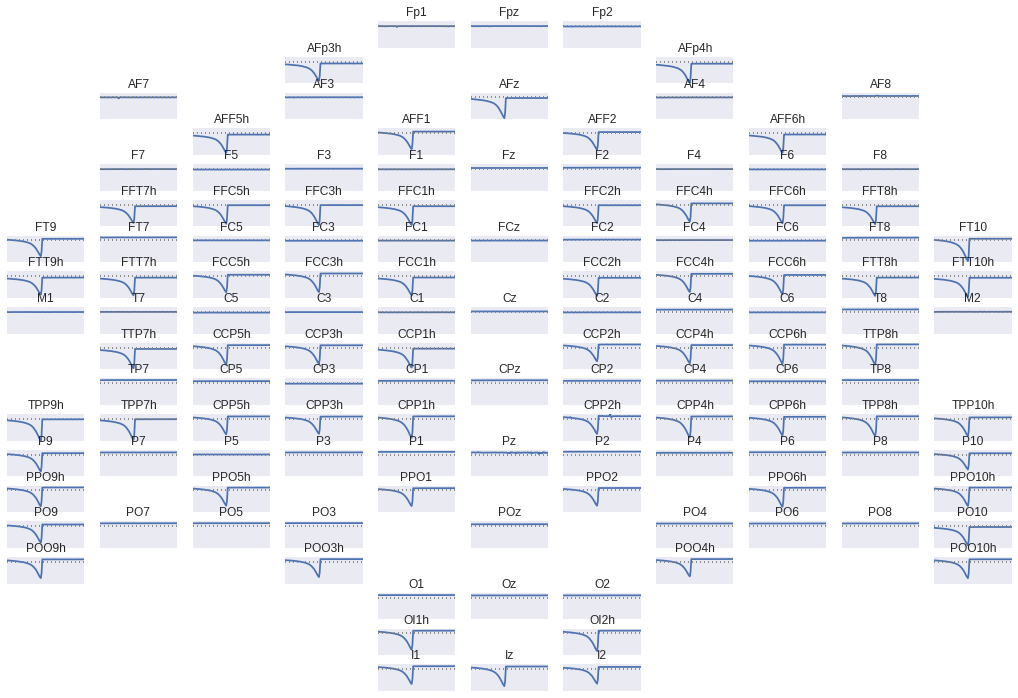

In [19]:
from braindecode.datasets.sensor_positions import tight_cap_positions
plot_head_signals_tight(np.mean(anwe_epo.data, axis=1).T[:,650:750], sensor_names=anwe_epo.axes[2],
                       sensor_map=tight_cap_positions, figsize=(18,12))
None

#### Scalp Plot

* Sensors with the drop in red

In [46]:
low_sensors = np.min(anwe_epo.data[650:750], axis=(0,1)) < -750 # 750 selected by visual inspection of plot

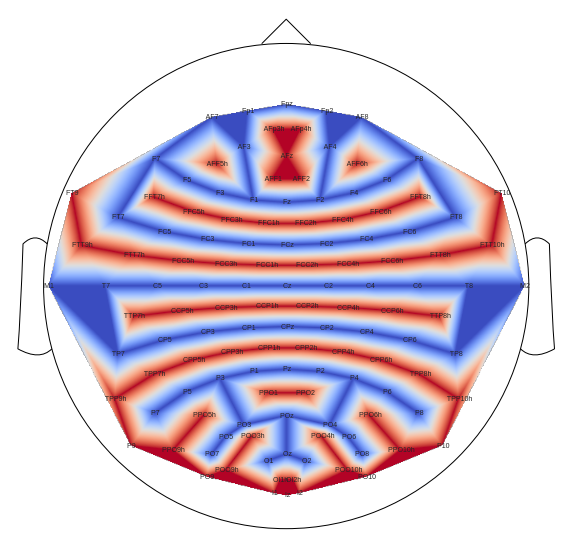

In [238]:
from braindecode.mywyrm.plot import ax_scalp

plt.figure(figsize=(10,10))
ax_scalp(low_sensors,anwe_epo.axes[2], colormap=cm.coolwarm, vmin=0,vmax=1, interpolation='bilinear', annotate=True)

#### Trial with negative drift

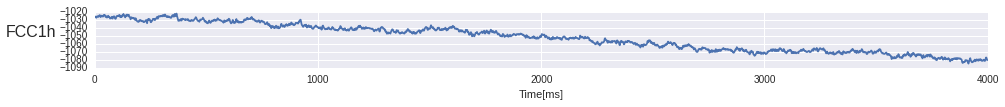

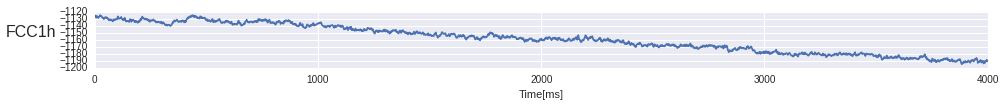

In [230]:
plt.plot(anwe_epo.data [689, :,anwe_epo.axes[2].tolist().index('FCC1h')])
plt.ylabel('FCC1h', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')
plt.figure(figsize=(16,1))
plt.plot(anwe_epo.data [690, :,anwe_epo.axes[2].tolist().index('FCC1h')])
plt.ylabel('FCC1h', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')

#### Clean trial as comparison

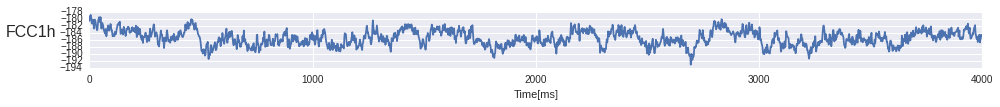

In [231]:
plt.plot(anwe_epo.data [650, :,anwe_epo.axes[2].tolist().index('FCC1h')])
plt.ylabel('FCC1h', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')

### Extreme and Fast Drops - variance increase

* On Single sensor, electrode losing contact?

In [41]:
from matplotlib import cm

#### Variance for all trials for all channels

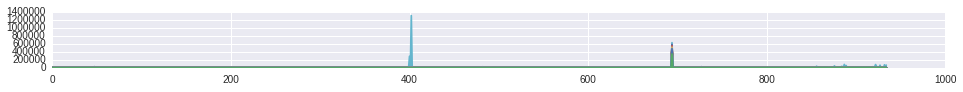

In [20]:
plt.plot(np.var(anwe_epo.data, axis=1))
None

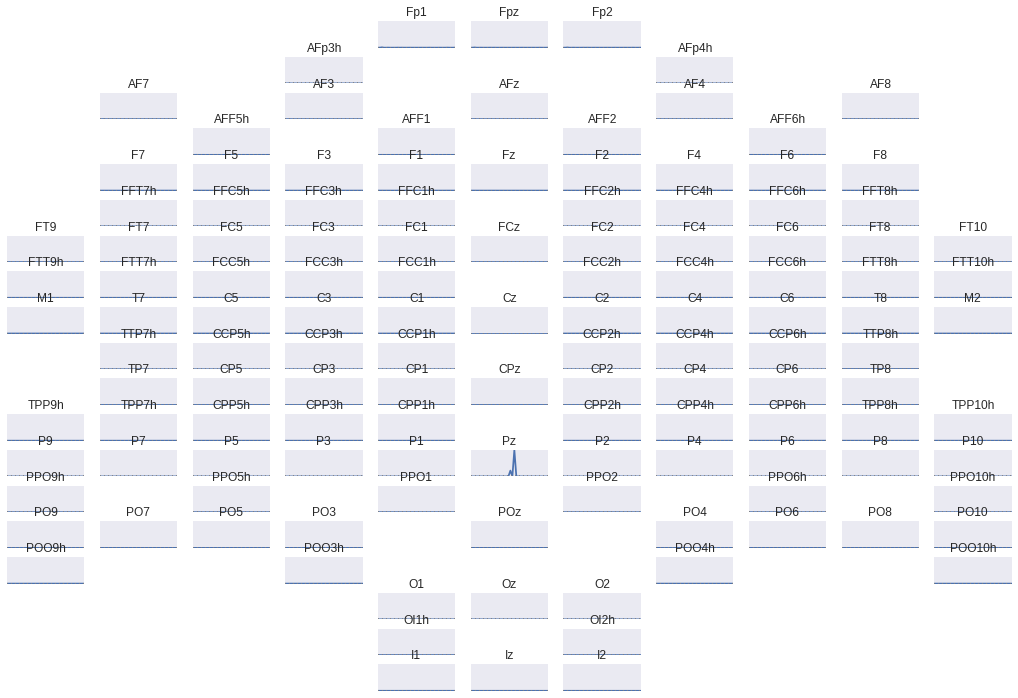

In [118]:
from braindecode.datasets.sensor_positions import tight_cap_positions
plot_head_signals_tight(np.var(anwe_epo.data, axis=1).T[:,380:420], sensor_names=anwe_epo.axes[2],
                       sensor_map=tight_cap_positions, figsize=(18,12))
None

### Drop Trial

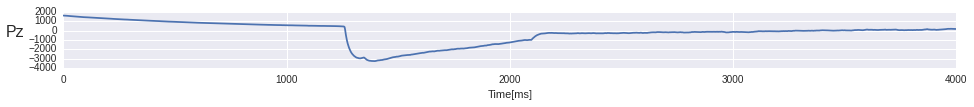

In [232]:
plt.plot(anwe_epo.data [402, :,anwe_epo.axes[2].tolist().index('Pz')]) # 402 determined by visual inspection

plt.ylabel('Pz', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')

### Regular Trial

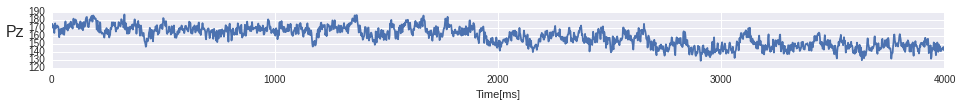

In [229]:
plt.plot(anwe_epo.data [395, :,anwe_epo.axes[2].tolist().index('Pz')])
plt.ylabel('Pz', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')

## Sudden Variance increase

* Variance incerases after some trial on several sensors - variance stays large afterwards
* Only visible when peak spikes of variance removed (here done by capping variance at 4000 for plot)

In [197]:
jobe_cnt = BBCIDataset('data/BBCI-without-last-runs/JoBeMoSc01S001R01_ds10_1-11.BBCI.mat').load()

In [198]:
marker_def = dict([(str(i_class), [i_class]) for i_class in range(1,5)])
jobe_epo = segment_dat_fast(jobe_cnt,marker_def=marker_def, ival=[0,4000])

### Variance for all trials per sensor

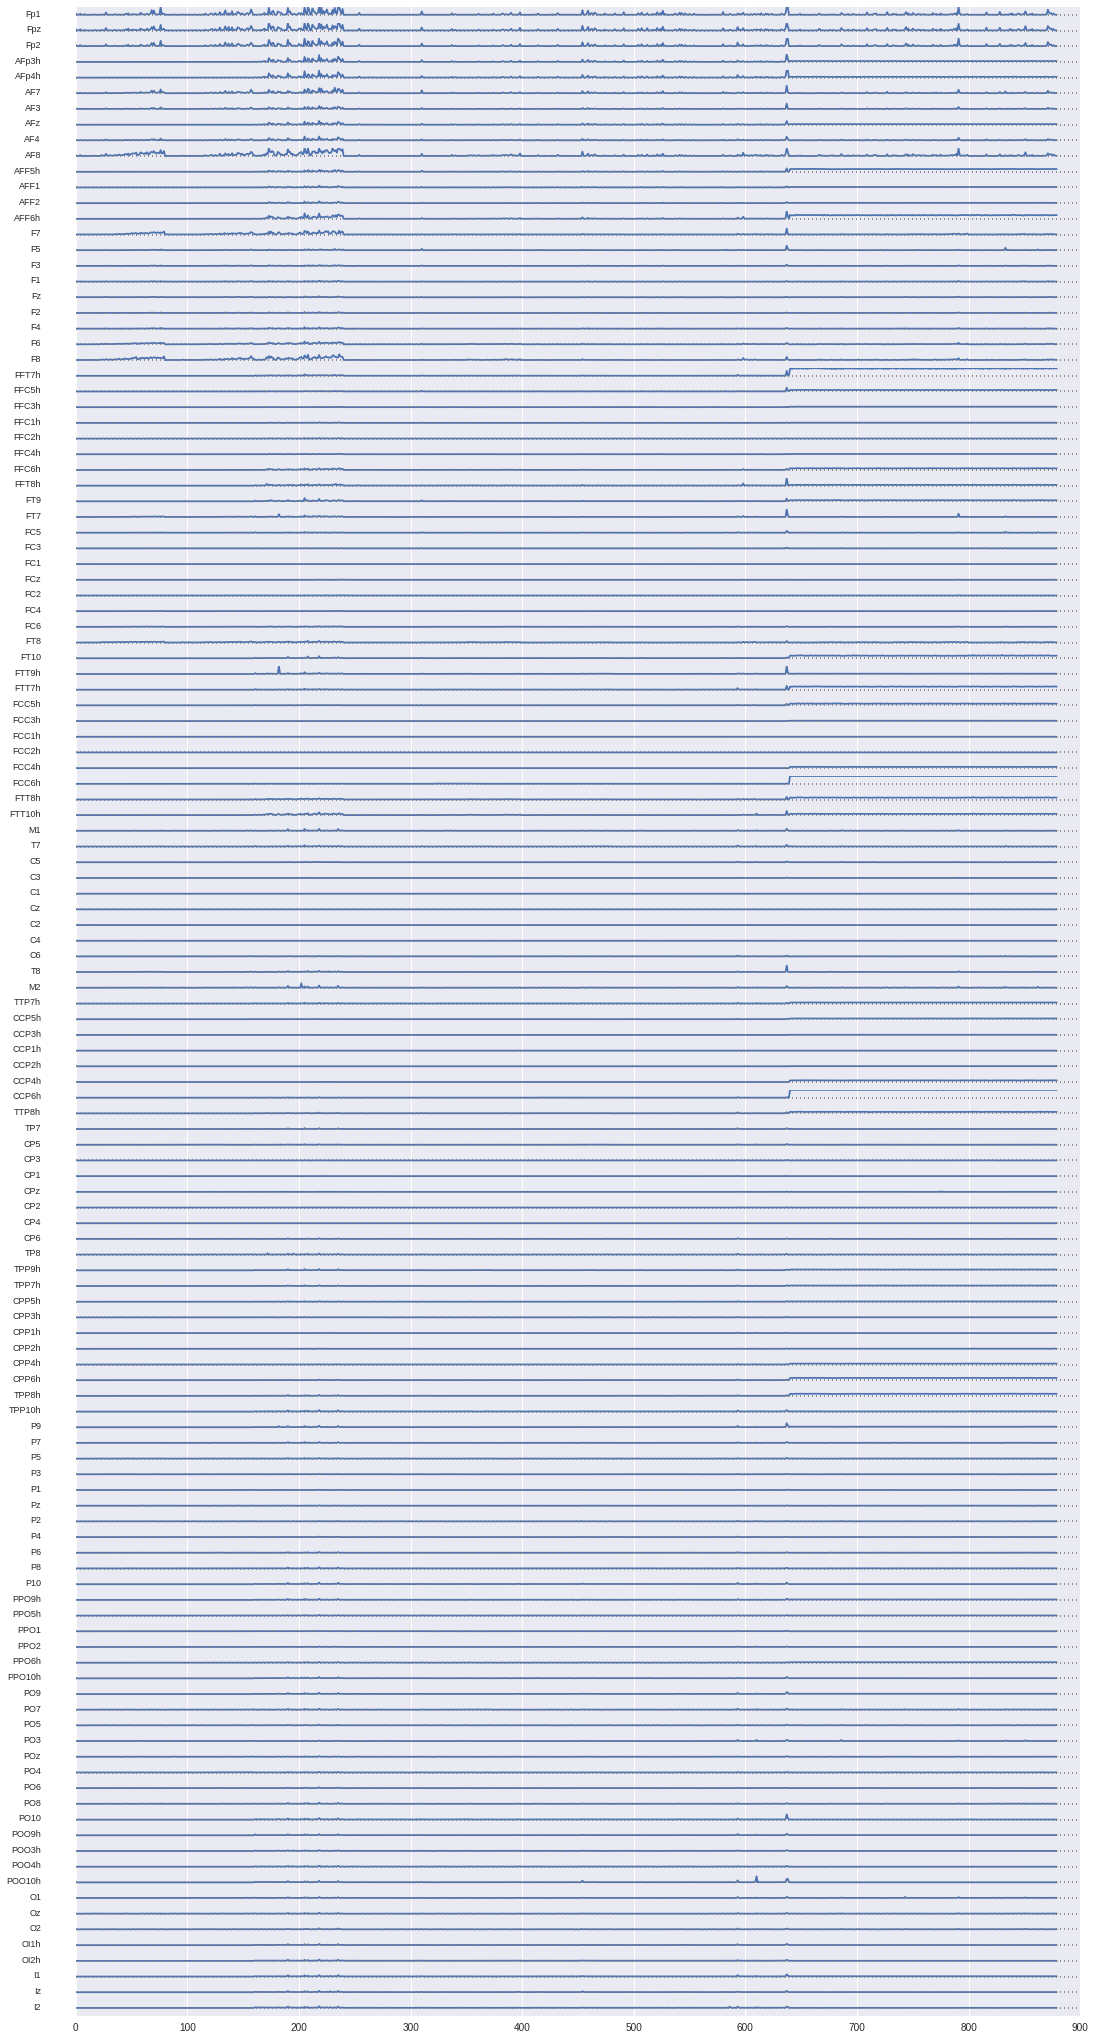

In [199]:
plot_sensor_signals(np.minimum(np.var(jobe_epo.data[:,:,:], axis=(1)),4000).T,
                   sensor_names=jobe_epo.axes[2],figsize=(18,36))
None

#### Topo Plot

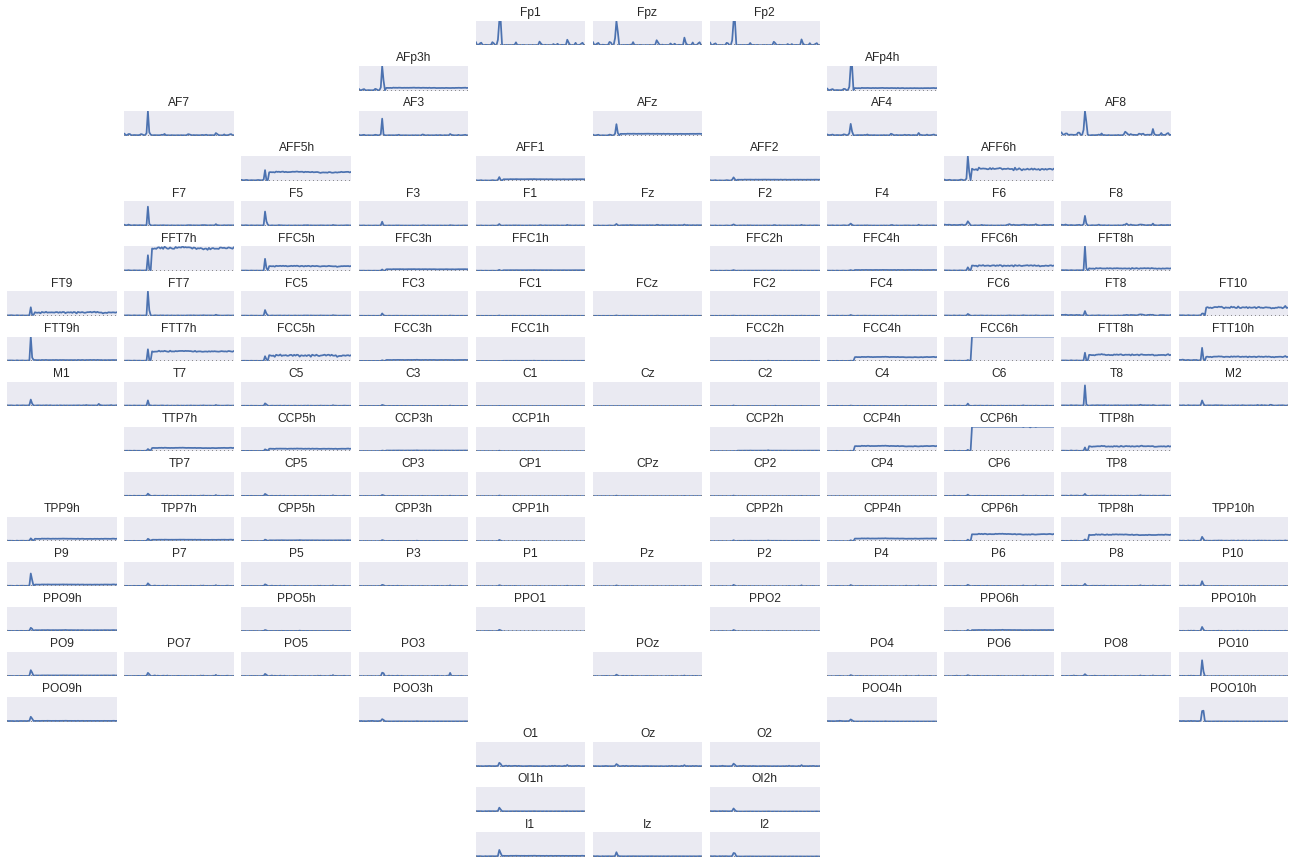

In [200]:
plot_head_signals_tight(np.minimum(np.var(jobe_epo.data[620:700,:,:], axis=(1)),4000).T,
                       sensor_names=jobe_epo.axes[2],
                       sensor_map=tight_cap_positions, figsize=(18,12))
plt.tight_layout()
None

#### Scalp Plot

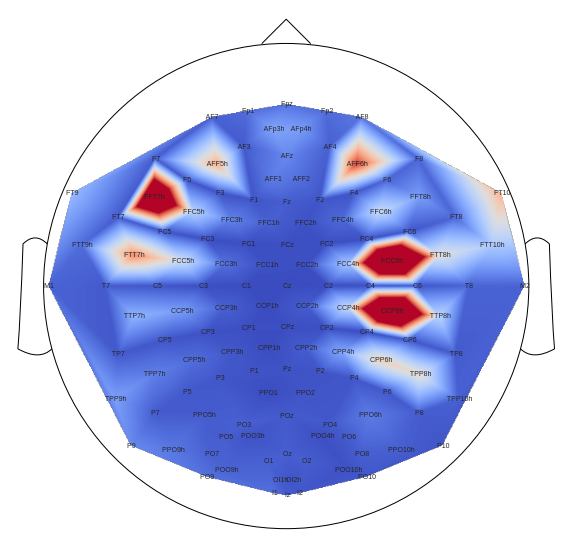

In [205]:

plt.figure(figsize=(10,10))
ax_scalp(np.mean(np.var(jobe_epo.data[660:700,:,:], axis=(1)), axis=(0)),
         jobe_epo.axes[2], colormap=cm.coolwarm, vmin=0,vmax=2000, interpolation='bilinear', annotate=True)

#### Trial with high variance

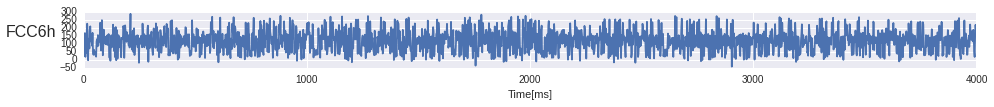

In [233]:
plt.plot(jobe_epo.data[640,:,jobe_epo.axes[2].tolist().index('FCC6h')])
plt.ylabel('FCC6h', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')

#### Trials before variance increase

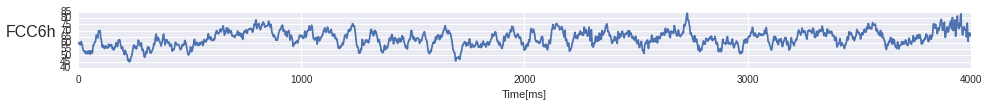

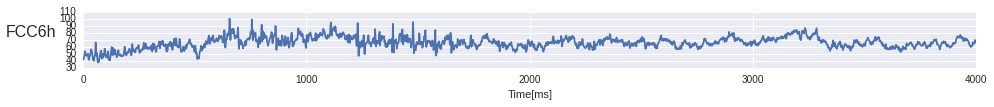

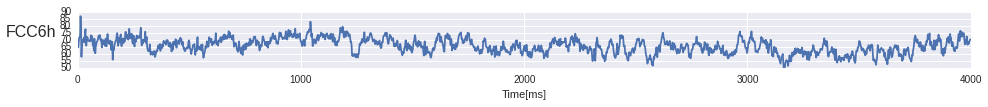

In [234]:
plt.plot(jobe_epo.data[636,:,jobe_epo.axes[2].tolist().index('FCC6h')])
plt.ylabel('FCC6h', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')
plt.figure(figsize=(16,1))
plt.plot(jobe_epo.data[638,:,jobe_epo.axes[2].tolist().index('FCC6h')])
plt.ylabel('FCC6h', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')
plt.figure(figsize=(16,1))

plt.plot(jobe_epo.data[639,:,jobe_epo.axes[2].tolist().index('FCC6h')])
plt.ylabel('FCC6h', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')


### A Blink

* just a blink :) 
* determined by variance spike

In [210]:
nama_cnt = BBCIDataset('data/BBCI-without-last-runs/NaMaMoSc1S001R01_ds10_1-11.BBCI.mat').load()

marker_def = dict([(str(i_class), [i_class]) for i_class in range(1,5)])
nama_epo = segment_dat_fast(nama_cnt,marker_def=marker_def, ival=[0,4000])

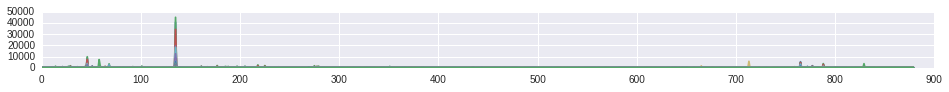

In [211]:
plt.plot(np.var(nama_epo.data[:,:,:], axis=(1)))
None

### Topo Plot

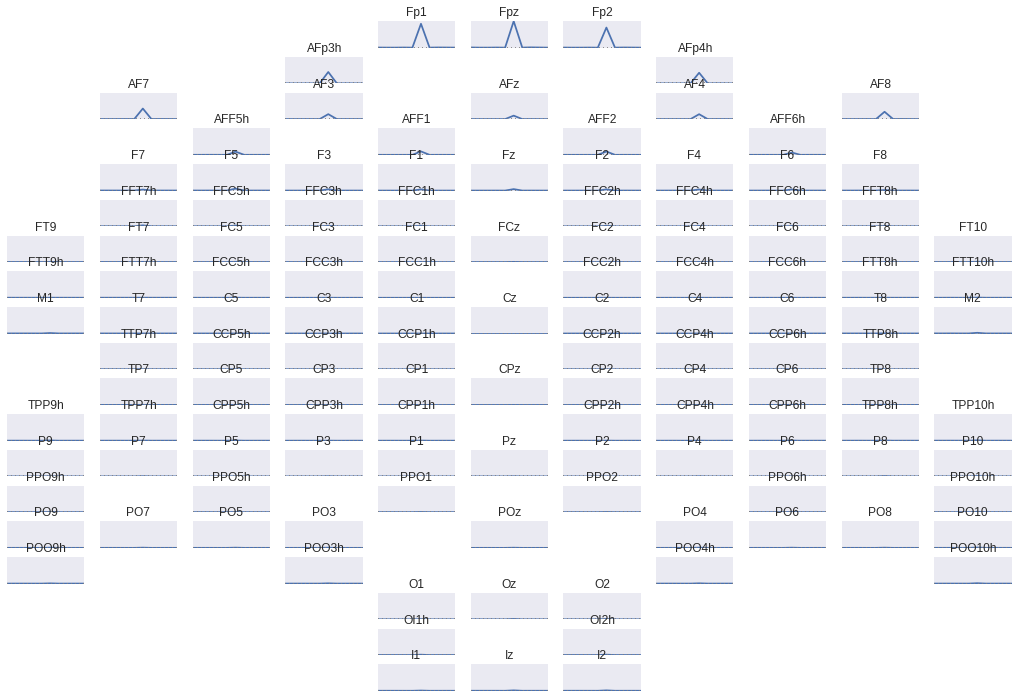

In [140]:
from braindecode.datasets.sensor_positions import tight_cap_positions
plot_head_signals_tight(np.var(nama_epo.data, axis=1).T[:,130:140], sensor_names=anwe_epo.axes[2],
                       sensor_map=tight_cap_positions, figsize=(18,12))
plt.tight_layout()
None

#### Scalp Plot

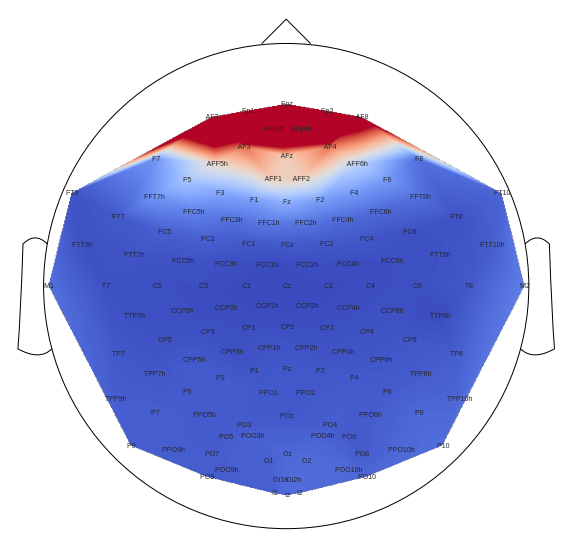

In [214]:

plt.figure(figsize=(10,10))
ax_scalp(np.var(nama_epo.data[135,:,:], axis=(0)),
         nama_epo.axes[2], colormap=cm.coolwarm, vmin=0,vmax=10000, interpolation='bilinear', annotate=True)

#### Trial

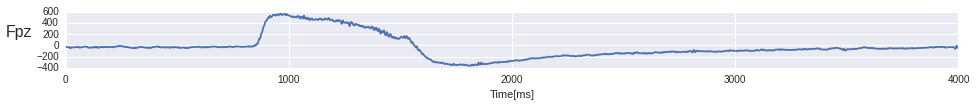

In [228]:
plt.plot(nama_epo.data[135,:,nama_epo.axes[2].tolist().index('Fpz')])
plt.ylabel('Fpz', rotation='horizontal', fontsize=16, ha='right')
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')

#### EOG Trial

In [218]:
nama_eog = BBCIDataset('data/BBCI-without-last-runs/NaMaMoSc1S001R01_ds10_1-11.BBCI.mat',
                      load_sensor_names=['EOGv', 'EOGh']).load()
nama_eog_epo = segment_dat_fast(nama_eog,marker_def=marker_def, ival=[0,4000])

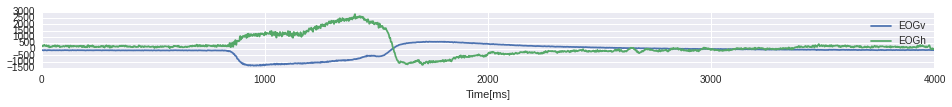

In [220]:
plt.plot(nama_eog_epo.data[135,:,:])
plt.legend(['EOGv', 'EOGh'])
plt.xticks(range(0,2001,500), range(0,4001,1000))
plt.xlabel('Time[ms]')